# 4. 신경망 학습
- 학습 : 훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 획득하는 것
- 손실 함수: 신경망이 학습 할 수 있도록 해주는 지표
  - 손실 함수의 결과값을 가장 작게 만드는 가중치 매개변수를 찾는 것이 학습의 목표

## 4.1 데이터에서 학습한다!
선형 분리 문제는 데이터로부터 자동으로 학습할 수 있다는 사실이 "퍼셉트론 수렴 정리(perceptron convergence theorem)"으로 증명  
하지만, 비선형 분리 문제는 자동으로 학습 할 수 없음  

### 4.1.1 데이터 주도 학습
- 기계 학습에서는 사람의 개입을 최소화하고 수집한 데이터로부터 패턴을 찾으려 시도
- 특징을 추출하고 그 특징의 패턴을 기계학습 기술로 학습하는 방법

#### 패러다임 전환
1. 데이터 -> 사람이 생각한 알고리즘 -> 결과
2. 데이터 -> 사람이 생각한 특징 -> 기계학습 -> 결과
3. 데이터 -> 신경망 -> 결과

### 4.1.2 훈련 데이터와 시험 데이터
- 훈련 데이터(training data): 학습을 통해 최적의 매개변수를 찾음
- 시험 데이터(test data): 앞서 훈련한 모델의 실력을 평가 (범용 능력 평가를 위해)

## 4.2 손실 함수 (loss function)
- 최적의 매개변수 값을 탐색하게 하는 기준이 되는 지표

### 4.2.1 평균 제곱 오차(MSE, Mean Squared Error)
- $E = {1 \over 2} \sum_k(y_k-t_k)^2$
- 예측값과 실제값의 차이의 제곱 평균

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [2]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] # 확률값

mean_squared_error(np.array(y), np.array(t))

0.09750000000000003

### 4.2.2 교차 엔트로피 오차(CEE, Cross Entropy Error)
- $E = -\sum_k t_k \log y_k$
- 교차 엔트로피에서 오차는, 정답일 때의 출력이 전체 값을 정하게 됨

In [18]:
def cross_entropy_error(y, t):
    delta = 1e-7 # inf 방지
    return -np.sum(t*np.log(y+delta))

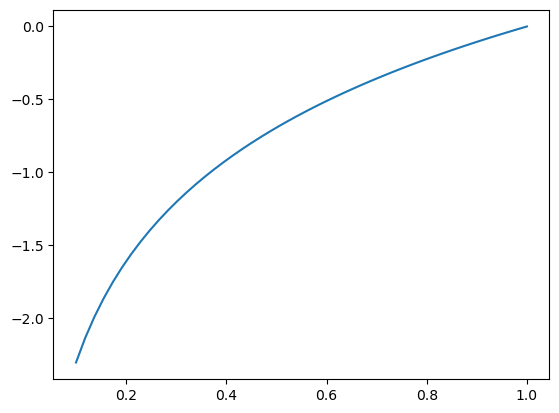

In [16]:
x = np.linspace(0.1, 1) # inf 방지
y = np.log(x)

plt.plot(x, y)
plt.show()

In [20]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] # 확률값

cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

### 4.2.3 미니배치 학습
- 훈련 데이터 모두에 대한 손실 함수의 합을 구하는 방법
  - CEE -> $E=-{1 \over N} \sum_n \sum_k t_{nk} \log y_{nk}$
  - 하나의 데이터에 대한 손실을 모두 다하고 정규화($1 \over N$)
- 데이터 일부를 추려 전체의 근사치로 이용 -> 미니배치(mini-batch)

In [3]:
# 데이터에서 지정한 수(미니배치 크기)만큼 무작위로 데이터를 추출하는 코드
import numpy as np
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [5]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

print(x_batch.shape)
print(t_batch.shape)

(10, 784)
(10, 10)


### 4.2.4 (배치용) 교차 엔트로피 오차 구현하기

In [7]:
# 원-핫 인코딩된 경우
def cross_entropy_error(y, t):
    if y.ndim==1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y)) / batch_size

# 원-핫 인코딩이 되지 않은 경우
def cross_entropy_error(y, t):
    if y.ndim==1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

### 4.2.5 왜 손실 함수를 설정하는가?
- 최적의 매개변수를 찾기 위해, 매개변수의 미분(기울기)을 계산하고, 이를 단서로 매개변수의 값을 서서히 갱신하는 과정을 반복 (손실함수의 값을 가능한 작게 만드는)
- 정확도는 매개변수의 미소한 변화에는 거의 반응을 보이지 않음
- 반응이 있다고 해도 불연속적으로 급변
- 계단 함수를 활성화 함수로 사용하지 않는 이유와도 들어맞음

## 4.3 수치 미분
### 4.3.1 미분
- 한순간의 변화량
- ${df(x) \over dx} = \lim_{h\rightarrow0} {f(x+h)-f(x) \over h}$

In [22]:
def numerical_diff(f, x):
    h = 1e-4 # 일반적으로 좋은 성능을 얻는다고 알려져 있음 (반올림 오차(rounding error) 방지)
    return (f(x+h) - f(x-h)) / (2*h) # 중심 차분 (중앙 차분) 적용

### 4.3.2 수치 미분의 예
$y=0.01x^2+0.1x$

In [23]:
def function_1(x):
    return 0.01 * x**2 + 0.1 * x

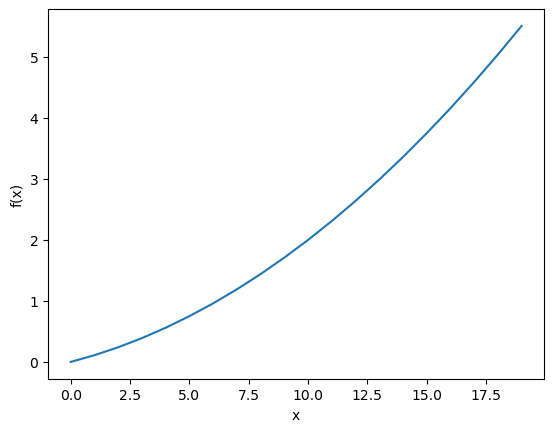

In [25]:
x = np.arange(0.0, 20.0, 1.0)
y = function_1(x)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [26]:
def funtion_1_prime(x):
    return 0.02 * x + 0.1

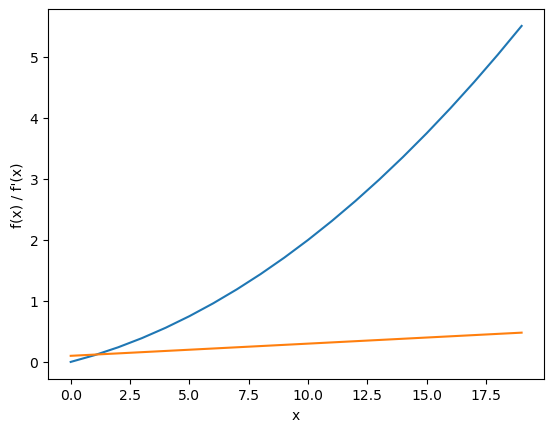

In [28]:
x = np.arange(0.0, 20.0, 1.0)
y = function_1(x)
yp = funtion_1_prime(x)

plt.xlabel("x")
plt.ylabel("f(x) / f'(x)")
plt.plot(x, y)
plt.plot(x, yp)
plt.show()

### 4.3.3 편미분
$f(x_0, x_1) = x_0^2 + x_1^2$

In [34]:
def funtion_2(x):
    return x[0]**2 + x[1]**2

$x_0=3, x_1=4 일때 {\delta f \over \delta x_0}$

In [35]:
def function_temp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_temp1, 3.0)

6.00000000000378

$x_0=3, x_1=4 일때 {\delta f \over \delta x_1}$

In [36]:
def function_temp2(x1):
    return 3.0**2.0 + x1*x1

numerical_diff(function_temp2, 4.0)

7.999999999999119

특정 장소의 기울기를 구함 (여러 변수 중 목표 변수 하나에 초점을 맞추고 다른 변수는 값을 고정)

## 4.4 기울기
- 값을 고정하지 않고, $({\delta f \over \delta x_0}, {\delta f \over \delta x_1})$ 처럼 모든 변수의 편미분을 벡터로 정리 -> 기울기(gradient)

In [37]:
def numeric_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        temp_val = x[idx]
        # f(x+h)
        x[idx] = temp_val+h
        fxh1 = f(x)
        # f(x-h)
        x[idx] = temp_val-h
        fxh2 = f(x)
        
        grad[idx] = (fxh1-fxh2)/(2*h)
        x[idx] = temp_val # 값 복원
        
    return grad       

In [38]:
numeric_gradient(funtion_2, np.array([3.0, 4.0]))

array([6., 8.])

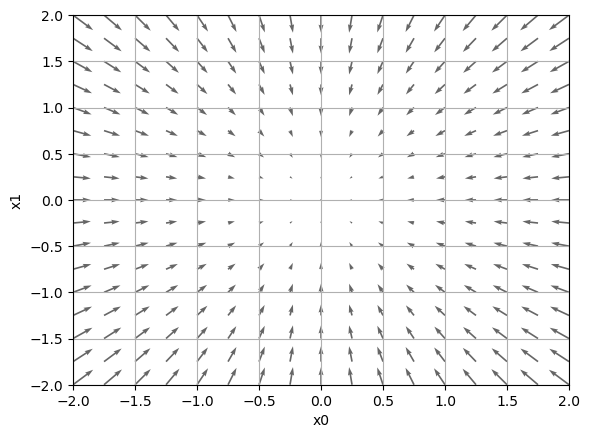

In [39]:
from mpl_toolkits.mplot3d import Axes3D

def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val 
        
    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad
    
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)
    
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]).T).T

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 줄이는 방향

### 4.4.1 경사법(경사 하강법)
- 기울어진 방향이 꼭 최솟값을 가리키는 것은 아니나, 그 방향으로 가야 함수의 값을 줄일 수 있음
- $x_0 = x_0 - \eta {\delta f \over \delta x_0}$
- $x_1 = x_1 - \eta {\delta f \over \delta x_1}$

$\eta$ -> 학습률(learning rate)

In [40]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numeric_gradient(f, x)
        x -= lr * grad
    return x

In [41]:
def funtion_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

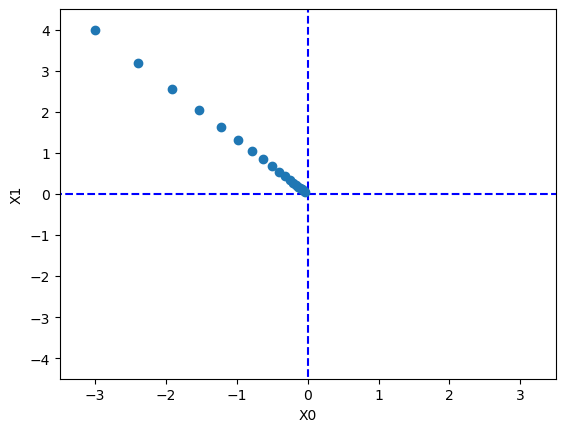

In [42]:
# 경사법에 의한 갱신 과정
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

### 4.4.2 신경망에서의 기울기
- 가중치 매개변수에 대한 손실 함수의 기울기

In [86]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size: t = t.argmax(axis=1)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        it.iternext()   
        
    return grad

In [88]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [89]:
net = simpleNet()

print(net.W)

[[-0.15674135  0.20673863 -0.35952196]
 [ 0.43145247  2.049452    0.02604483]]


In [90]:
x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

p = net.predict(x)

print(p)

[ 0.29426241  1.96854998 -0.19227282]


In [91]:
np.argmax(p)

1

In [92]:
net.loss(x, t)

2.425239168189307

In [97]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.086334    0.46059127 -0.54692527]
 [ 0.129501    0.6908869  -0.8203879 ]]


## 4.5 학습 알고리즘 구현하기
0. 전제
   - 신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 학습이라 함
1. 미니배치
   - 훈련 데이터 중 일부를 무작위로 가져옴
   - 미니배치의 손실 함수 값을 줄이는 것이 목표
2. 기울기 산출
   - 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구함
   - 기울기는 함수의 값을 가장 작게 하는 방향을 제시
3. 매개변수 갱신
   - 가중치 매개변수를 기울기 방향으로 갱신
4. 반복

데이터를 미니배치로 무작위로 선정하기 때문에 **확률적 경사 하강법(SGD, Stochastic Gradient Descent)**이라고 함

### 4.5.1 2층 신경망 클래스 구현하기


In [115]:
from common.functions import *
from common.gradient import numerical_gradient

# Ref. CS231n
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

In [116]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

print(net.params["W1"].shape) # 784, 100
print(net.params["b1"].shape) # 100,
print(net.params["W2"].shape) # 100, 10
print(net.params["b2"].shape) # 10,

(784, 100)
(100,)
(100, 10)
(10,)


In [117]:
# 예측 처리
x = np.random.randn(100, 784)
y = net.predict(x)

In [118]:
# 기울기 계산
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

print(grads["W1"].shape) # 784, 100
print(grads["b1"].shape) # 100,
print(grads["W2"].shape) # 100, 10
print(grads["b2"].shape) # 10,

(784, 100)
(100,)
(100, 10)
(10,)


### 4.5.2 미니배치 학습 구현하기

In [ ]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 하이퍼파라미터
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate*grad[key]
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

### 4.5.3 시험 데이터로 평가하기

In [124]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 하이퍼파라미터
iters_num = 100
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1 에포크당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    if i%10==0:
        print(f"EPOCHS: {i}")
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate*grad[key]
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    # 1 에포크당 정확도 계산
    if i%iter_per_epoch==0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"train acc, test acc | {train_acc:.5f}, {test_acc:.3f}")

EPOCHS: 0
train acc, test acc | 0.10322, 0.102
EPOCHS: 10
EPOCHS: 20
EPOCHS: 30
EPOCHS: 40
EPOCHS: 50
EPOCHS: 60
EPOCHS: 70
EPOCHS: 80
EPOCHS: 90
